
# Data Description

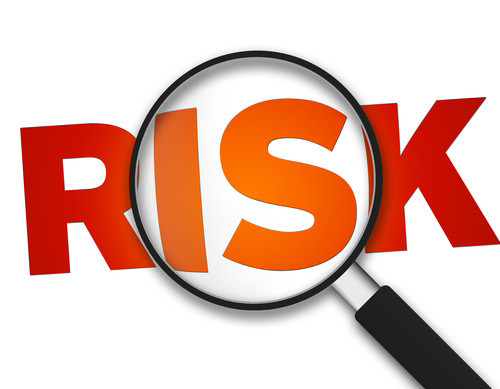

## Context
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.

## Content
It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose(text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others
- Risk (Value target - Good or Bad Risk)


# 1. Installing

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# it's a library that we work with plotly
import plotly.offline as py 
py.init_notebook_mode(connected=True)                  # this code, allow us to work with offline plotly version
import plotly.graph_objs as go                         # it's like "plt" of matplot
import plotly.tools as tls                             # It's useful to we get some tools of plotly
from collections import Counter                        # To do counter of some features
import plotly.figure_factory as ff




from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV                                         # to split the data
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, classification_report, fbeta_score     # to evaluate our model

# Algorithmns models to be compared
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


import warnings

from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.pandas.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print(14 * " >", "\t n.B.a. \t", "< " * 14, "\n\n\n")

# 2. EDA (Exploratory of Data Analysis)
## 2.1. Data Preperation

In [ ]:
df = pd.read_csv("../input/german-credit-data-with-risk/german_credit_data.csv", index_col=0)
df.head()

Let's check NaN values:

In [ ]:
df.isnull().sum()

and check what we have for instance missing value and numeric/object fature observing:

In [ ]:
df.info()

In [ ]:
cat_cols = [col for col in df.columns if df[col].dtypes == 'O']

for col in cat_cols:
    print(df[col].value_counts(), "\n\n")

See 'Target' variable distribution with visual:

In [ ]:
trace0 = go.Bar(
            x = df[df["Risk"]== 'good']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'good']["Risk"].value_counts().values,
            name='Good credit')

trace1 = go.Bar(
            x = df[df["Risk"]== 'bad']["Risk"].value_counts().index.values,
            y = df[df["Risk"]== 'bad']["Risk"].value_counts().values,
            name='Bad credit')


data = [trace0, trace1]
layout = go.Layout(
    yaxis=dict(
        title='Count'
    ),
    xaxis=dict(
        title='Risk Variable'
    ),
    title='Target variable distribution'
)

fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"
py.iplot(fig, filename='grouped-bar')

## 2.2. Numerical Variable Analysis

In [ ]:
num_cols = [col for col in df.columns if df[col].dtypes != 'O' and col not in "Id"]
print('Number of Numerical Variable: ', len(num_cols))


def hist_for_nums(data, numeric_cols):
    col_counter = 0
    data = data.copy()
    for col in numeric_cols:
        data[col].plot.hist(alpha=0.5, color='y')
        plt.xlabel(col)
        plt.title(col)
        plt.show()
        col_counter += 1
    print(col_counter, "variables have been plotted")


hist_for_nums(df, num_cols)

Let's see general version:

In [ ]:
df_good = df.loc[df["Risk"] == 'good']['Age'].values.tolist()
df_bad = df.loc[df["Risk"] == 'bad']['Age'].values.tolist()
df_age = df['Age'].values.tolist()

#First plot
trace0 = go.Histogram(
    x=df_good,
    histnorm='probability',
    name="Good Credit"
)
#Second plot
trace1 = go.Histogram(
    x=df_bad,
    histnorm='probability',
    name="Bad Credit"
)
#Third plot
trace2 = go.Histogram(
    x=df_age,
    histnorm='probability',
    name="Overall Age"
)

#Creating the grid
fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Good','Bad', 'General Distribuition'))

#setting the figs
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig['layout'].update(showlegend=True, title='Age Distribuition', bargap=0.05)
py.iplot(fig, filename='custom-sized-subplot-with-subplot-titles')

See together in graphs accordings to Frequency and Count:

In [ ]:
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

fig, ax = plt.subplots(nrows=2, figsize=(12,8))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

g1 = sns.distplot(df_good["Age"], ax=ax[0], 
             color="g")
g1 = sns.distplot(df_bad["Age"], ax=ax[0], 
             color='r')
g1.set_title("Age Distribuition", fontsize=15)
g1.set_xlabel("Age")
g1.set_xlabel("Frequency")

g2 = sns.countplot(x="Age",data=df, 
              palette="hls", ax=ax[1], 
              hue = "Risk")
g2.set_title("Age Counting by Risk", fontsize=15)
g2.set_xlabel("Age")
g2.set_xlabel("Count")
plt.show()

It can be seen that the "Age" variable is very important. Because of the need, I create categorical variables according to the Age variable. And let's re-create df_bad dataframes with df_good we created.

In [ ]:
#Let's look the Credit Amount column
interval = (18, 25, 35, 60, 120)

cats = ['Student', 'Young', 'Adult', 'Senior']
df["Age_cat"] = pd.cut(df.Age, interval, labels=cats)

# And let's re-create "df_bad" dataframes with "df_good" we created.
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

Let's visualize it again according to the last created.

In [ ]:
trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Age_cat"],
    name='Good credit',
    marker=dict(
        color='LightSkyBlue'
    )
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Age_cat'],
    name='Bad credit',
    marker=dict(
        color='DarkSlateGrey'
    )
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount (US Dollar)',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')



Now let's look at the breakdown of Leaseholder and Rent by Risk:

In [ ]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Housing"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Housing"].value_counts().values,
    name='Good credit'
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Housing"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Housing"].value_counts().values,
    name="Bad Credit"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Housing Distribuition'
)


fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"

py.iplot(fig, filename='Housing-Grouped')

### Distribuition of Credit Amount by Housing visualization:

Focus on the highest values ​​come from the category of "free" and we have a different distribution by Risk.

In [ ]:
fig = {
    "data": [
        {
            "type": 'violin',
            "x": df_good['Housing'],
            "y": df_good['Credit amount'],
            "legendgroup": 'Good Credit',
            "scalegroup": 'No',
            "name": 'Good Credit',
            "side": 'negative',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": '#673D43'
            }
        },
        {
            "type": 'violin',
            "x": df_bad['Housing'],
            "y": df_bad['Credit amount'],
            "legendgroup": 'Bad Credit',
            "scalegroup": 'No',
            "name": 'Bad Credit',
            "side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": '#AB9C2B'
            }
        }
    ],
    "layout" : {
        "yaxis": {
            "zeroline": False,
        },
        "violingap": 0,
        "violinmode": "overlay"
    }
}


py.iplot(fig, filename = 'violin/split', validate = False)



### Looking the diference by Sex visualization:


In [ ]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Sex"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Sex"].value_counts().values,
    name='Good credit'
)

#First plot 2
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Sex"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Sex"].value_counts().values,
    name="Bad Credit"
)

#Second plot
trace2 = go.Box(
    x = df[df["Risk"]== 'good']["Sex"],
    y = df[df["Risk"]== 'good']["Credit amount"],
    name=trace0.name
)

#Second plot 2
trace3 = go.Box(
    x = df[df["Risk"]== 'bad']["Sex"],
    y = df[df["Risk"]== 'bad']["Credit amount"],
    name=trace1.name
)

data = [trace0, trace1, trace2,trace3]

fig = tls.make_subplots(rows=1, cols=2, 
                        subplot_titles=('Sex Count', 'Credit Amount by Sex'))

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 2)

fig['layout'].update(height=400, width=800, title='Sex Distribuition', boxmode='group')
py.iplot(fig, filename='sex-subplot')

Let's create age categories and look at the distribution of Loan Amount by Riskand try to do some research on Credit Amount by Age Crossed Work, and Distribution.

### Distribuition

In [ ]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Job"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Job"].value_counts().values,
    name='Good credit Distribuition'
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Job"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Job"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Job Distribuition'
)

fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"
py.iplot(fig, filename='grouped-bar')

### Crossed by Credit amount and Age

In [ ]:
trace0 = go.Box(
    x=df_good["Job"],
    y=df_good["Credit amount"],
    name='Good credit',
    marker=dict(
        color='LightSkyBlue')
)

trace1 = go.Box(
    x=df_bad['Job'],
    y=df_bad['Credit amount'],
    name='Bad credit',
    marker=dict(
        color='DarkSlateGrey')
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Credit Amount distribuition by Job',
        zeroline=False
    ),
    xaxis=dict(
        title='Age Categorical'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')




In [ ]:
fig = {
    "data": [
        {
            "type": 'violin',
            "x": df_good['Job'],
            "y": df_good['Age'],
            "legendgroup": 'Good Credit',
            "scalegroup": 'No',
            "name": 'Good Credit',
            "side": 'negative',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": '#673D43'
            }
        },
        {
            "type": 'violin',
            "x": df_bad['Job'],
            "y": df_bad['Age'],
            "legendgroup": 'Bad Credit',
            "scalegroup": 'No',
            "name": 'Bad Credit',
            "side": 'positive',
            "box": {
                "visible": True
            },
            "meanline": {
                "visible": True
            },
            "line": {
                "color": 'green'
            }
        }
    ],
    "layout" : {
        "yaxis": {
            "zeroline": False,
        },
        "violingap": 0,
        "violinmode": "overlay"
    }
}


py.iplot(fig, filename = 'Age-Housing', validate = False)

See relation between:
- Credit Amount by Job, 
- Job Reference, 
- Credit Amount,
- Job Type reference by Age,
- Job Reference

In [ ]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2)

g1 = sns.boxplot(x="Job", y="Credit amount", data=df, 
            palette="husl", ax=ax[0], hue="Risk")
g1.set_title("Credit Amount by Job", fontsize=15)
g1.set_xlabel("Job Reference", fontsize=12)
g1.set_ylabel("Credit Amount", fontsize=12)

g2 = sns.violinplot(x="Job", y="Age", data=df, ax=ax[1],  
               hue="Risk", split=True, palette="Blues")
g2.set_title("Job Type reference x Age", fontsize=15)
g2.set_xlabel("Job Reference", fontsize=12)
g2.set_ylabel("Age", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()



### The distribuition of Credit Amont:

In [ ]:
# Add histogram data
x1 = np.log(df_good['Credit amount']) 
x2 = np.log(df_bad["Credit amount"])

# Group data together
hist_data = [x1, x2]

group_labels = ['Good Credit', 'Bad Credit']
colors = ['rgb(0, 0, 100)', 'rgb(0, 200, 200)']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.1, colors=colors)

# Plot!
py.iplot(fig, filename='Distplot with Multiple Datasets')

### Credit Amount Frequency distribuition:

In [ ]:
#Ploting the good and bad dataframes in distplot
plt.figure(figsize = (8,5))

g= sns.distplot(df_good['Credit amount'], color='y')
g = sns.distplot(df_bad["Credit amount"], color='g')
g.set_title("Credit Amount Frequency distribuition", fontsize=18)
plt.show()

### Distruibution of Saving accounts by Risk:

In [ ]:
count_good = go.Bar(
    x = df_good["Saving accounts"].value_counts().index.values,
    y = df_good["Saving accounts"].value_counts().values,
    name='Good credit'
)
count_bad = go.Bar(
    x = df_bad["Saving accounts"].value_counts().index.values,
    y = df_bad["Saving accounts"].value_counts().values,
    name='Bad credit'
)


box_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Credit amount"],
    name='Good credit'
)
box_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Credit amount"],
    name='Bad credit'
)

scat_1 = go.Box(
    x=df_good["Saving accounts"],
    y=df_good["Age"],
    name='Good credit'
)
scat_2 = go.Box(
    x=df_bad["Saving accounts"],
    y=df_bad["Age"],
    name='Bad credit'
)

data = [scat_1, scat_2, box_1, box_2, count_good, count_bad]

fig = tls.make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                          subplot_titles=('Count Saving Accounts','Credit Amount by Savings Acc', 
                                          'Age by Saving accounts'))

fig.append_trace(count_good, 1, 1)
fig.append_trace(count_bad, 1, 1)

fig.append_trace(box_2, 1, 2)
fig.append_trace(box_1, 1, 2)

fig.append_trace(scat_1, 2, 1)
fig.append_trace(scat_2, 2, 1)



fig['layout'].update(height=700, width=800, title='Saving Accounts Exploration', boxmode='group')

py.iplot(fig, filename='combined-savings')

Lets see together another version:

In [ ]:
print("Description of Distribuition Saving accounts by Risk:  ")
print(pd.crosstab(df["Saving accounts"],df.Risk))

fig, ax = plt.subplots(3,1, figsize=(12,12))
g = sns.countplot(x="Saving accounts", data=df, palette="husl", 
              ax=ax[0],hue="Risk")
g.set_title("Saving Accounts Count", fontsize=15)
g.set_xlabel("Saving Accounts type", fontsize=12)
g.set_ylabel("Count", fontsize=12)

g1 = sns.violinplot(x="Saving accounts", y="Job", data=df, palette="Blues", 
               hue = "Risk", ax=ax[1],split=True)
g1.set_title("Saving Accounts by Job", fontsize=15)
g1.set_xlabel("Savings Accounts type", fontsize=12)
g1.set_ylabel("Job", fontsize=12)

g = sns.boxplot(x="Saving accounts", y="Credit amount", data=df, ax=ax[2],
            hue = "Risk",palette="pastel")
g2.set_title("Saving Accounts by Credit Amount", fontsize=15)
g2.set_xlabel("Savings Accounts type", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)

plt.subplots_adjust(hspace = 0.4,top = 0.9)

plt.show()

Let's try to see which products they want to buy according to their ages and their quantities.

In [ ]:
print("Values describe: ")
print(pd.crosstab(df.Purpose, df.Risk))

plt.figure(figsize = (14,12))

plt.subplot(221)
g = sns.countplot(x="Purpose", data=df, 
              palette="husl", hue = "Risk")
g.set_xticklabels(g.get_xticklabels(),rotation=45)
g.set_xlabel("", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Purposes Count", fontsize=20)

plt.subplot(222)
g1 = sns.violinplot(x="Purpose", y="Age", data=df, 
                    palette="Blues", hue = "Risk",split=True)
g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
g1.set_xlabel("", fontsize=12)
g1.set_ylabel("Count", fontsize=12)
g1.set_title("Purposes by Age", fontsize=20)

plt.subplot(212)
g2 = sns.boxplot(x="Purpose", y="Credit amount", data=df, 
               palette="Set2", hue = "Risk")
g2.set_xlabel("Purposes", fontsize=12)
g2.set_ylabel("Credit Amount", fontsize=12)
g2.set_title("Credit Amount distribuition by Purposes", fontsize=20)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

plt.show()

### Duration of the credits distribuition and density:
As seen, the 12th, 18th and 20th months are the time periods with the highest distribution.

In [ ]:


plt.figure(figsize = (12,14))

g= plt.subplot(311)
g = sns.countplot(x="Duration", data=df, 
              palette="husl",  hue = "Risk")
g.set_xlabel("Duration Distribuition", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Duration Count", fontsize=20)

g1 = plt.subplot(312)
g1 = sns.pointplot(x="Duration", y ="Credit amount",data=df,
                   hue="Risk", palette="Set2")
g1.set_xlabel("Duration", fontsize=12)
g1.set_ylabel("Credit Amount(US)", fontsize=12)
g1.set_title("Credit Amount distribuition by Duration", fontsize=20)

g2 = plt.subplot(313)
g2 = sns.distplot(df_good["Duration"], color='y')
g2 = sns.distplot(df_bad["Duration"], color='b')
g2.set_xlabel("Duration", fontsize=12)
g2.set_ylabel("Frequency", fontsize=12)
g2.set_title("Duration Frequency x good and bad Credit", fontsize=20)

plt.subplots_adjust(wspace = 0.4, hspace = 0.4,top = 0.9)

plt.show()



### Checking Account variable

First, let's look the distribuition:

In [ ]:
#First plot
trace0 = go.Bar(
    x = df[df["Risk"]== 'good']["Checking account"].value_counts().index.values,
    y = df[df["Risk"]== 'good']["Checking account"].value_counts().values,
    name='Good credit Distribuition' 
    
)

#Second plot
trace1 = go.Bar(
    x = df[df["Risk"]== 'bad']["Checking account"].value_counts().index.values,
    y = df[df["Risk"]== 'bad']["Checking account"].value_counts().values,
    name="Bad Credit Distribuition"
)

data = [trace0, trace1]

layout = go.Layout(
    title='Checking accounts Distribuition',
    xaxis=dict(title='Checking accounts name'),
    yaxis=dict(title='Count'),
    barmode='group'
)


fig = go.Figure(data=data, layout=layout)
fig.data[0].marker.line.width = 4
fig.data[0].marker.line.color = "black"
fig.data[1].marker.line.width = 4
fig.data[1].marker.line.color = "black"
py.iplot(fig, filename = 'Age-ba', validate = False)

Now, we will verify the values through Checking Accounts

In [ ]:
df_good = df[df["Risk"] == 'good']
df_bad = df[df["Risk"] == 'bad']

trace0 = go.Box(
    y=df_good["Credit amount"],
    x=df_good["Checking account"],
    name='Good credit'
)

trace1 = go.Box(
    y=df_bad['Credit amount'],
    x=df_bad['Checking account'],
    name='Bad credit'
    
)
    
data = [trace0, trace1]

layout = go.Layout(
    yaxis=dict(
        title='Cheking distribuition'
    ),
    boxmode='group'
)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='box-age-cat')

Now let's try to perform a merge between variables according to the above.

In [ ]:
print("Total values of the most missing variable: ")
print(df.groupby("Checking account")["Checking account"].count())

plt.figure(figsize = (12,10))

g = plt.subplot(221)
g = sns.countplot(x="Checking account", data=df, 
              palette="husl", hue="Risk")
g.set_xlabel("Checking Account", fontsize=12)
g.set_ylabel("Count", fontsize=12)
g.set_title("Checking Account Counting by Risk", fontsize=20)

g1 = plt.subplot(222)
g1 = sns.violinplot(x="Checking account", y="Age", data=df, palette="Set2", hue = "Risk",split=True)
g1.set_xlabel("Checking Account", fontsize=12)
g1.set_ylabel("Age", fontsize=12)
g1.set_title("Age by Checking Account", fontsize=20)

g2 = plt.subplot(212)
g2 = sns.boxplot(x="Checking account",y="Credit amount", data=df,hue='Risk',palette="pastel")
g2.set_xlabel("Checking Account", fontsize=12)
g2.set_ylabel("Credit Amount(US)", fontsize=12)
g2.set_title("Credit Amount by Cheking Account", fontsize=20)

plt.subplots_adjust(wspace = 0.2, hspace = 0.3, top = 0.9)

plt.show()
plt.show()

### The distribution of having a job with hosting:

In [ ]:
plt.figure(figsize = (10,6))

g = sns.violinplot(x="Housing",y="Job",data=df,
                   hue="Risk", palette="deep", as_cmap=True, split=True)
g.set_xlabel("Housing", fontsize=12)
g.set_ylabel("Job", fontsize=12)
g.set_title("Housing x Job - Dist", fontsize=20)

plt.show()

Let's illustrate with numbers and crosstab:

In [ ]:

print("Job status by gender", pd.crosstab(df.Sex, df.Job), sep="\n\n")


print("\n\n\nAccount status by gender\n\n", pd.crosstab(df["Checking account"],df.Sex))

In [ ]:
date_int = ["Purpose", 'Sex']
#cm = sns.light_palette("green", as_cmap=True)
pd.crosstab(df[date_int[0]], df[date_int[1]]).style.background_gradient(cmap = "viridis")


# 3. Data Prepcoressing & Feature Engineering
## 3.1. Missing Values Analysis

In [ ]:
def missing_values_table(dataframe):
    variables_with_na = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[variables_with_na].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[variables_with_na].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df)
    return variables_with_na


missing_values_table(df)

Filling missing values with mode

In [ ]:
#Filling missing values with mode
df["Saving accounts"].fillna(df['Saving accounts'].mode()[0], inplace=True)
df["Checking account"].fillna(df['Checking account'].mode()[0], inplace=True)

## 3.2. Outliers Analysis

In [ ]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def has_outliers(dataframe, num_col_names, plot=False):
    variable_names = []
    for col in num_col_names:
        low_limit, up_limit = outlier_thresholds(dataframe, col)
        if dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].any(axis=None):
            number_of_outliers = dataframe[(dataframe[col] > up_limit) | (dataframe[col] < low_limit)].shape[0]
            print(col, ":", number_of_outliers)
            variable_names.append(col)
            if plot:
                sns.boxplot(x=dataframe[col])
                plt.show()
    return variable_names


has_outliers(df, num_cols)

Now, set thresholds(low and up limits) for outliers then use for outliers

In [ ]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    replace_with_thresholds(df, col)

has_outliers(df, num_cols)

In [ ]:
df.head()

In [ ]:
df["Risk"].value_counts()

## 3.3. Label Encoding & One-Hot Encoding

First, observe the Label Encoding & One-Hot Encoding.


In [ ]:
# cat_cols = [col for col in df.columns if df[col].dtypes == 'O']


# def one_hot_encoder(dataframe, categorical_cols, nan_as_category=True):
#     original_columns = list(dataframe.columns)
#     dataframe = pd.get_dummies(dataframe, columns=categorical_cols, dummy_na=nan_as_category, drop_first=True)
#     new_columns = [c for c in dataframe.columns if c not in original_columns]
#     return dataframe, new_columns


# df, new_cols_ohe = one_hot_encoder(df, cat_cols)

You can use the above method as a secondary method, but let's try to examine it one by one.

In [ ]:
#Purpose to Dummies Variable
df = df.merge(pd.get_dummies(df.Purpose, drop_first=True, prefix='Purpose'), left_index=True, right_index=True)
#Sex feature in dummies
df = df.merge(pd.get_dummies(df.Sex, drop_first=True, prefix='Sex'), left_index=True, right_index=True)
# Housing get dummies
df = df.merge(pd.get_dummies(df.Housing, drop_first=True, prefix='Housing'), left_index=True, right_index=True)
# Housing get Saving Accounts
df = df.merge(pd.get_dummies(df["Saving accounts"], drop_first=True, prefix='Savings'), left_index=True, right_index=True)
# Housing get Risk
df = df.merge(pd.get_dummies(df.Risk, prefix='Risk'), left_index=True, right_index=True)
# Housing get Checking Account
df = df.merge(pd.get_dummies(df["Checking account"], drop_first=True, prefix='Check'), left_index=True, right_index=True)
# Housing get Age categorical
df = df.merge(pd.get_dummies(df["Age_cat"], drop_first=True, prefix='Age_cat'), left_index=True, right_index=True)

Let's drop categorical and at the same time old variables.

In [ ]:
droplist=["Sex","Housing","Saving accounts","Checking account","Purpose","Risk","Risk_good","Age_cat"]

df.drop(droplist, axis= 1, inplace = True)

## 3.4. Standardization

In [ ]:
like_num = [col for col in df.columns if df[col].dtypes != 'O' and len(df[col].value_counts()) < 20]


cols_need_scale = [col for col in df.columns if col not in "Id"
                   and col not in "Risk"
                   and col not in like_num]

df[cols_need_scale].head()
df[cols_need_scale].describe([0.05, 0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.95, 0.99]).T
hist_for_nums(df, cols_need_scale)


def robust_scaler(variable):
    var_median = variable.median()
    quartile1 = variable.quantile(0.25)
    quartile3 = variable.quantile(0.75)
    interquantile_range = quartile3 - quartile1
    if int(interquantile_range) == 0:
        quartile1 = variable.quantile(0.05)
        quartile3 = variable.quantile(0.95)
        interquantile_range = quartile3 - quartile1
        z = (variable - var_median) / interquantile_range
        return round(z, 3)
    else:
        z = (variable - var_median) / interquantile_range
    return round(z, 3)


for col in cols_need_scale:
    df[col] = robust_scaler(df[col])


df[cols_need_scale].head()
df[cols_need_scale].describe().T
hist_for_nums(df, cols_need_scale)



## 3.5. Correlation and Heatmap Analysis

Then look at the correlations between target and independent variables.

In [ ]:
plt.figure(figsize=(20,13))
sns.heatmap(df.corr(),
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            annot_kws={'size':16},
            cbar=False)


## 4. Modelling

In [ ]:
#Creating the X and y variables
X = df.drop('Risk_bad', 1).values
y = df["Risk_bad"].values

# Spliting X and y into train and test version
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [ ]:
# to feed the random state
seed = 7

# prepare models
models = []
# models.append(('LR', LinearRegression()))
# models.append(('RDR', Ridge()))
# models.append(('LSSR', Lasso()))
# models.append(('ER', ElasticNet()))
models.append(('LGR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('XGBM', XGBClassifier()))
models.append(('LGBM', LGBMClassifier()))


# evaluate each model in turn
results = []
names = []
scoring = 'recall'

for name, model in models:
        kfold = KFold(n_splits=10, random_state=seed)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
fig = plt.figure(figsize=(11,6))
fig.suptitle('Algorithms Compare')
ax = fig.add_subplot(111)
green_diamond = dict(markerfacecolor='g', marker='D')
plt.boxplot(results, flierprops=green_diamond, patch_artist=True)
ax.set_xticklabels(names)
plt.show()

The Naive Bayes, Decision Tree, LightGBM and XGBoost models are seen as the best methods. Let's subject them to hyperparameter optimization using the verification method one by one.

### 4.1. Gaussian Naive Bayes Model

In [ ]:
from sklearn.utils import resample
from sklearn.metrics import roc_curve

GNB = GaussianNB()

# Fitting with train data
model = GNB.fit(X_train, y_train)

print("Primitive error evaluation accuracy score: ", model.score(X_train, y_train))

y_pred = model.predict(X_test)

print("Test predict accuracy score: ", accuracy_score(y_test,y_pred),"\n")

print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")

print("Classification report according to Test prediction: \n", classification_report(y_test, y_pred))


The Naive Bayes model seems to be the best method. Let's see ROC curve for predict probability:

In [ ]:
#Predicting proba
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate', color="r")
plt.ylabel('True Positive Rate', color="g")
plt.title('ROC Curve')
plt.show()

### 4.2. XGBOOST Model

In [ ]:
xgb = XGBClassifier(random_state = 12345)

xgb_params = {
    "learning_rate": [0.01, 0.1, 0.2, 1],
    "min_samples_split": np.linspace(0.1, 0.5, 10),
    "max_depth":[3,5,8],
    "subsample":[0.5, 0.9, 1.0],
    "n_estimators": [100,1000]}

xgb_cv_model  = GridSearchCV(xgb,xgb_params, cv = 5, n_jobs = -1, verbose = 2).fit(X, y)    # i did cv=5 this is not enough and this is for faster estimate

xgb_tuned = XGBClassifier(**xgb_cv_model.best_params_).fit(X,y)
cross_val_score(xgb_tuned, X, y, cv = 10).mean()

### 4.3. LightGBM Model

In [ ]:
# model tuning

lgbm = LGBMClassifier()
lgbm_params = {"learning_rate": [0.01, 0.03, 0.05, 0.1, 0.5],
               "n_estimators": [500, 1000, 1500],
               "max_depth": [3,5,8]}

#GridSearchCV method
gs_cv = GridSearchCV(lgbm,
                     lgbm_params,
                     cv=5,                                  # i did cv=5 this is not enough and this is for faster estimate
                     n_jobs=-1,
                     verbose=2).fit(X_train, y_train)

#En iyi parametrelerle model kurma
lgbm_tuned = LGBMClassifier(**gs_cv.best_params_).fit(X, y)
cross_val_score(lgbm_tuned, X_test, y_test, cv=10).mean()

#cv islemleri(caprazlama)
kfold = KFold(n_splits=10, random_state=123456)
cv_results = cross_val_score(LGBMClassifier(), X_train, y_train, cv=kfold, scoring="accuracy")
cv_results.mean()

### 4.4. Pipeline Method
Select features according to the k highest scores and Principal Component Analysis(PCA) then we will apply Logistic Regression with feature union.

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest


features = []
features.append(('PCA', PCA(n_components=2)))
features.append(('Select_best', SelectKBest(k=6)))
feature_union = FeatureUnion(features)

# create pipeline
estimators = []
estimators.append(('Feature_union', feature_union))
estimators.append(('Logistic_regression', LogisticRegression()))
model = Pipeline(estimators)

# evaluate pipeline
seed = 7
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(model, X_train, y_train, cv=kfold)
print(results.mean())

In [ ]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Test predict accuracy score: {:.2f}".format(accuracy_score(y_test,y_pred)),"\n")

print("Confussion Matrix: \n", confusion_matrix(y_test, y_pred),"\n")

print("Weighted harmonic mean of precision according to Test prediction: ", fbeta_score(y_test, y_pred, beta=2))

Let me explain what is the "fbeta_score":

> The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0.

> The beta parameter determines the weight of recall in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall (beta -> 0 considers only precision, beta -> +inf only recall).



## 5. Conclusion

We got different accuracy scores in the all of model estimation evaluation. A very successful modeling has been realized.
Note:

   - I took advantage of the https://www.kaggle.com/kabure/predicting-credit-risk-model-pipeline/comments kernel, especially the visuals, but I tried to create a smoother notebook by fixing the problems a lot. But of course I would like to thank him :)
   - This is also reference notebook https://www.kaggle.com/mathchi/predict-sales-prices-and-practice-feature-engineer
   
   - Recommend: If you want to see high accuracy score then try to CV=10.
   - After this notebook, my aim is to prepare 'kernel' which is 'not clear' data set.

   - If you have any suggestions, please could you write for me? I wil be happy for comment and critics!

   - Thank you for your comment, suggestion and votes ;)
